In [ ]:
import os
import cv2
import kagglehub    
import numpy as np
import pandas as pd
import tkinter as tk
import mediapipe as mp

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns   
import pickle

import pyautogui    

# HAND LANDMARK BY MEDIAPIPE

In [4]:
# Download dataset
path = kagglehub.dataset_download("ahmedkhairy11/signclusive-mediapipe")
print("Path to dataset files:", path)

Path to dataset files: C:\Users\PC\.cache\kagglehub\datasets\ahmedkhairy11\signclusive-mediapipe\versions\2


In [5]:
os.listdir(path)

['hand_keypoints.csv', 'Signclusive_Mediapipe']

In [6]:
df = pd.read_csv(os.path.join(path, os.listdir(path)[0]))  # Đọc dữ liệu từ file CSV
df

,folder,filename,x0,y0,x1,y1,x2,y2,x3,y3,x4,y4,x5,y5,x6,y6,x7,y7,x8,y8,x9,y9,x10,y10,x11,y11,x12,y12,x13,y13,x14,y14,x15,y15,x16,y16,x17,y17,x18,y18,x19,y19,x20,y20
0,A,0.jpg,0.195703,0.405481,0.251328,0.378401,0.293216,0.316613,0.300587,0.247013,0.307915,0.191208,0.266657,0.258304,0.270158,0.217391,0.257446,0.258795,0.248646,0.303211,0.233192,0.259327,0.237716,0.218482,0.229082,0.275692,0.223791,0.328507,0.203282,0.266353,0.206562,0.234668,0.203106,0.295886,0.202290,0.343694,0.173678,0.279436,0.178582,0.258264,0.179206,0.306023,0.180974,0.342326
1,A,1.jpg,0.195529,0.405478,0.250318,0.381913,0.292142,0.316723,0.299324,0.245252,0.307751,0.190003,0.265923,0.257694,0.269781,0.219616,0.257483,0.262675,0.249017,0.308013,0.232326,0.257979,0.236615,0.216884,0.229574,0.277069,0.225315,0.331206,0.202886,0.264972,0.205216,0.233352,0.203890,0.297427,0.204136,0.345952,0.173469,0.278215,0.178356,0.256779,0.178933,0.307816,0.180801,0.345445
2,A,10.jpg,0.199760,0.439257,0.256980,0.407103,0.297316,0.346919,0.303871,0.277043,0.311055,0.220881,0.270808,0.289103,0.271742,0.243940,0.259746,0.288613,0.251878,0.336198,0.237024,0.290477,0.238354,0.249480,0.230739,0.308828,0.227470,0.362896,0.206418,0.298276,0.208962,0.267113,0.206354,0.328144,0.206453,0.376744,0.175420,0.311579,0.179300,0.288815,0.180942,0.337820,0.183392,0.376473
3,A,100.jpg,0.434312,0.610718,0.486101,0.579385,0.526760,0.509808,0.545438,0.448159,0.559467,0.397122,0.500281,0.449152,0.513461,0.419310,0.505249,0.468176,0.495609,0.509806,0.468647,0.448034,0.482736,0.428208,0.474856,0.490145,0.468192,0.537019,0.437908,0.454377,0.450005,0.443824,0.446199,0.506696,0.443862,0.549600,0.407171,0.465315,0.419606,0.447975,0.421281,0.496033,0.421153,0.530726
4,A,101.jpg,0.434486,0.611838,0.485553,0.581089,0.526583,0.511406,0.545746,0.448663,0.560368,0.397514,0.500708,0.449132,0.513202,0.418149,0.505509,0.467740,0.496165,0.509113,0.468872,0.447948,0.482321,0.427882,0.475361,0.489416,0.469024,0.535316,0.438219,0.454411,0.449313,0.443685,0.447067,0.506588,0.445705,0.549681,0.408148,0.465337,0.420222,0.448556,0.422920,0.496758,0.423455,0.531869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13445,Z,95.jpg,0.543389,0.690129,0.573396,0.644894,0.577207,0.579888,0.530378,0.567881,0.489026,0.570837,0.518691,0.488121,0.470669,0.441673,0.438107,0.419096,0.404862,0.384535,0.480036,0.511056,0.480407,0.557252,0.519998,0.602248,0.535748,0.596183,0.455298,0.549148,0.466676,0.606283,0.502975,0.635023,0.513394,0.611654,0.442698,0.592084,0.462910,0.643030,0.494147,0.663131,0.501410,0.648445
13446,Z,96.jpg,0.546894,0.692147,0.573311,0.643575,0.575460,0.580134,0.532204,0.567320,0.492933,0.567810,0.516736,0.486699,0.469269,0.439577,0.435369,0.415247,0.402445,0.383990,0.478524,0.511277,0.480026,0.556198,0.516981,0.598141,0.532238,0.591702,0.454553,0.551340,0.466260,0.607394,0.498509,0.633780,0.507865,0.609385,0.442182,0.596556,0.459174,0.645259,0.488287,0.662773,0.496062,0.645961
13447,Z,97.jpg,0.546894,0.692147,0.573311,0.643575,0.575460,0.580134,0.532204,0.567320,0.492933,0.567810,0.516736,0.486699,0.469269,0.439577,0.435369,0.415247,0.402445,0.383990,0.478524,0.511277,0.480026,0.556198,0.516981,0.598141,0.532238,0.591702,0.454553,0.551340,0.466260,0.607394,0.498509,0.633780,0.507865,0.609385,0.442182,0.596556,0.459174,0.645259,0.488287,0.662773,0.496062,0.645961
13448,Z,98.jpg,0.541922,0.691008,0.571177,0.644842,0.575759,0.580257,0.530485,0.566425,0.488095,0.568390,0.518301,0.488108,0.468465,0.437375,0.437155,0.413367,0.406047,0.380424,0.480954,0.513574,0.477904,0.549993,0.514973,0.594445,0.530036,0.588763,0.456845,0.552518,0.465330,0.601717,0.499415,0.630296,0.508793,0.606571,0.443497,0.596244,0.460300,0.639810,0.489140,0.657877,0.495169,0.642112


In [7]:
os.listdir(os.path.join(path, os.listdir(path)[1]))    

['Signclusive_Mediapipe']

In [8]:
IMG_PATH = os.path.join(path, os.listdir(path)[1] + '\Signclusive_Mediapipe')
token = os.listdir(IMG_PATH)
token 

['A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'space',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z']

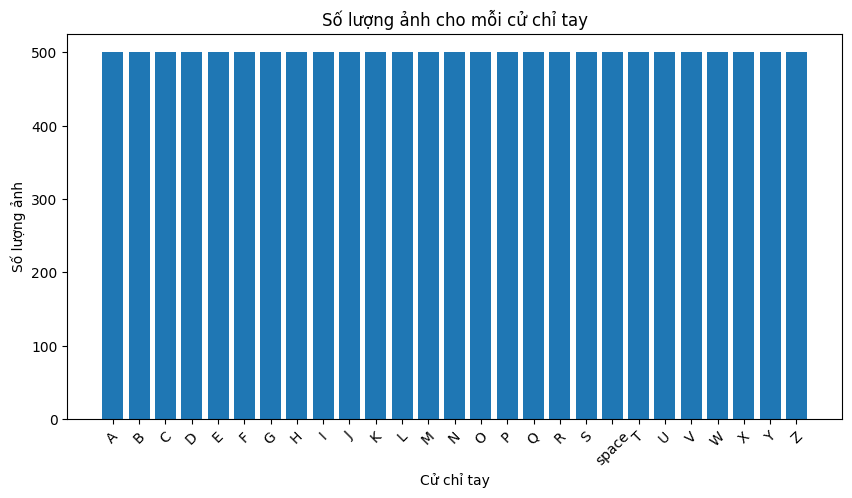

In [9]:
count_token = dict() 
for i in token:
    count_token[i] = len(os.listdir(os.path.join(IMG_PATH, i)))
plt.figure(figsize=(10, 5))
plt.bar(count_token.keys(), count_token.values())   
plt.xlabel('Cử chỉ tay')    
plt.ylabel('Số lượng ảnh')
plt.title('Số lượng ảnh cho mỗi cử chỉ tay')
plt.xticks(rotation=45)
plt.show()  


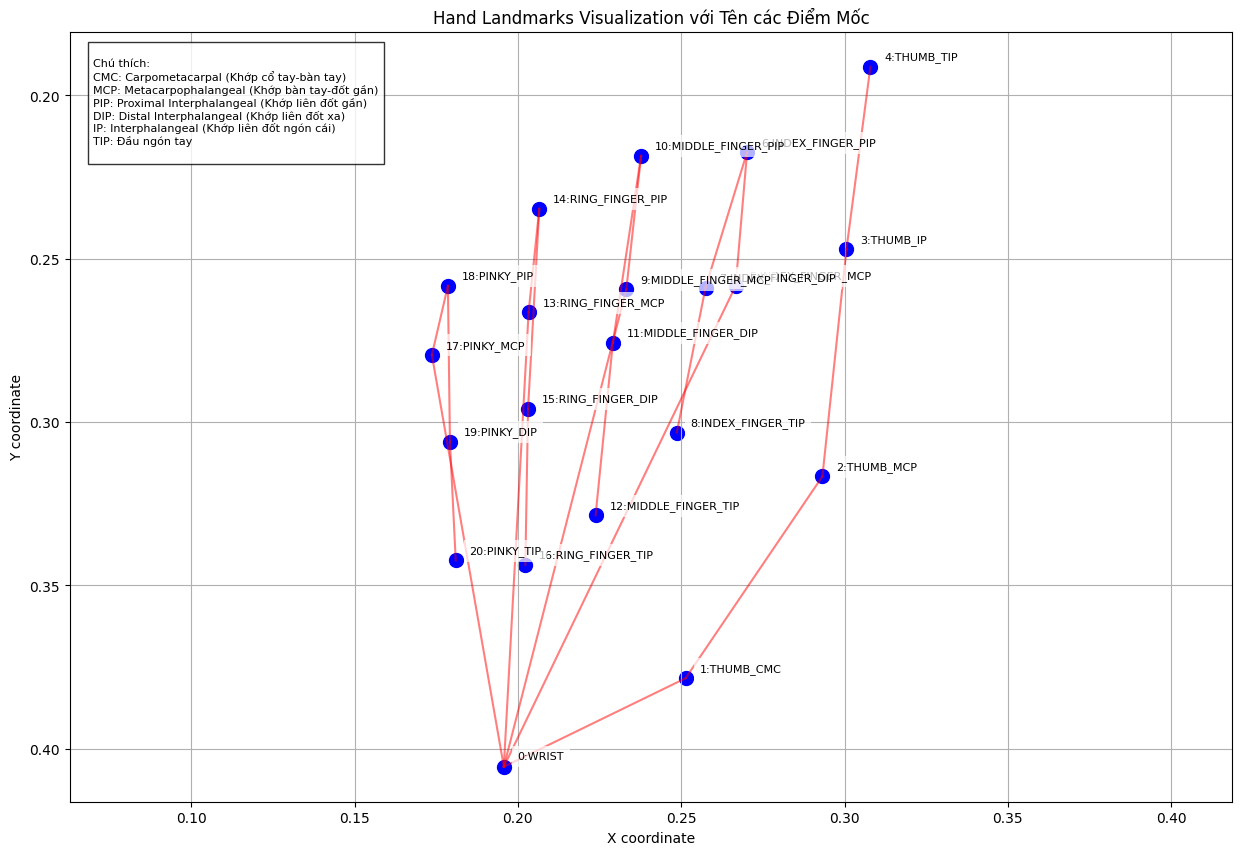

In [10]:
# Định nghĩa tên các điểm mốc
landmark_names = [
    'WRIST',  # 0
    'THUMB_CMC', 'THUMB_MCP', 'THUMB_IP', 'THUMB_TIP',  # 1-4
    'INDEX_FINGER_MCP', 'INDEX_FINGER_PIP', 'INDEX_FINGER_DIP', 'INDEX_FINGER_TIP',  # 5-8
    'MIDDLE_FINGER_MCP', 'MIDDLE_FINGER_PIP', 'MIDDLE_FINGER_DIP', 'MIDDLE_FINGER_TIP',  # 9-12
    'RING_FINGER_MCP', 'RING_FINGER_PIP', 'RING_FINGER_DIP', 'RING_FINGER_TIP',  # 13-16
    'PINKY_MCP', 'PINKY_PIP', 'PINKY_DIP', 'PINKY_TIP'  # 17-20
]

# Lấy một mẫu dữ liệu để visualization (ví dụ: mẫu đầu tiên)
sample_data = df.iloc[0, 2:].values.reshape(-1, 2)  # Reshape thành mảng Nx2 cho coordinates x,y

# Tạo figure với kích thước lớn hơn
plt.figure(figsize=(15, 10))

# Vẽ scatter plot cho các điểm mốc
plt.scatter(sample_data[:, 0], sample_data[:, 1], c='blue', s=100)

# Thêm tên cho từng điểm
for i, (x, y) in enumerate(sample_data):
    plt.annotate(f'{i}:{landmark_names[i]}', (x, y), 
                xytext=(10, 5), textcoords='offset points',
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.7),
                fontsize=8)

# Vẽ các đường nối giữa các điểm mốc để tạo hình dạng bàn tay
# Định nghĩa các connections giữa các điểm mốc (dựa trên MediaPipe hand landmarks)
connections = [
    (0, 1), (1, 2), (2, 3), (3, 4),  # Ngón cái (Thumb)
    (0, 5), (5, 6), (6, 7), (7, 8),  # Ngón trỏ (Index finger)
    (0, 9), (9, 10), (10, 11), (11, 12),  # Ngón giữa (Middle finger)
    (0, 13), (13, 14), (14, 15), (15, 16),  # Ngón áp út (Ring finger)
    (0, 17), (17, 18), (18, 19), (19, 20)  # Ngón út (Pinky)
]

# Vẽ các đường nối
for start, end in connections:
    plt.plot([sample_data[start, 0], sample_data[end, 0]], 
             [sample_data[start, 1], sample_data[end, 1]], 
             'r-', alpha=0.5)

plt.title('Hand Landmarks Visualization với Tên các Điểm Mốc')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')

# Thêm chú thích cho các phần của bàn tay
plt.text(0.02, 0.98, '''
Chú thích:
CMC: Carpometacarpal (Khớp cổ tay-bàn tay)
MCP: Metacarpophalangeal (Khớp bàn tay-đốt gần)
PIP: Proximal Interphalangeal (Khớp liên đốt gần)
DIP: Distal Interphalangeal (Khớp liên đốt xa)
IP: Interphalangeal (Khớp liên đốt ngón cái)
TIP: Đầu ngón tay
''', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.8),
         fontsize=8, verticalalignment='top')

# Đảo ngược trục y để match với coordinate system của ảnh
plt.gca().invert_yaxis()

# Cân bằng tỷ lệ các trục
plt.axis('equal')

plt.grid(True)
plt.show()

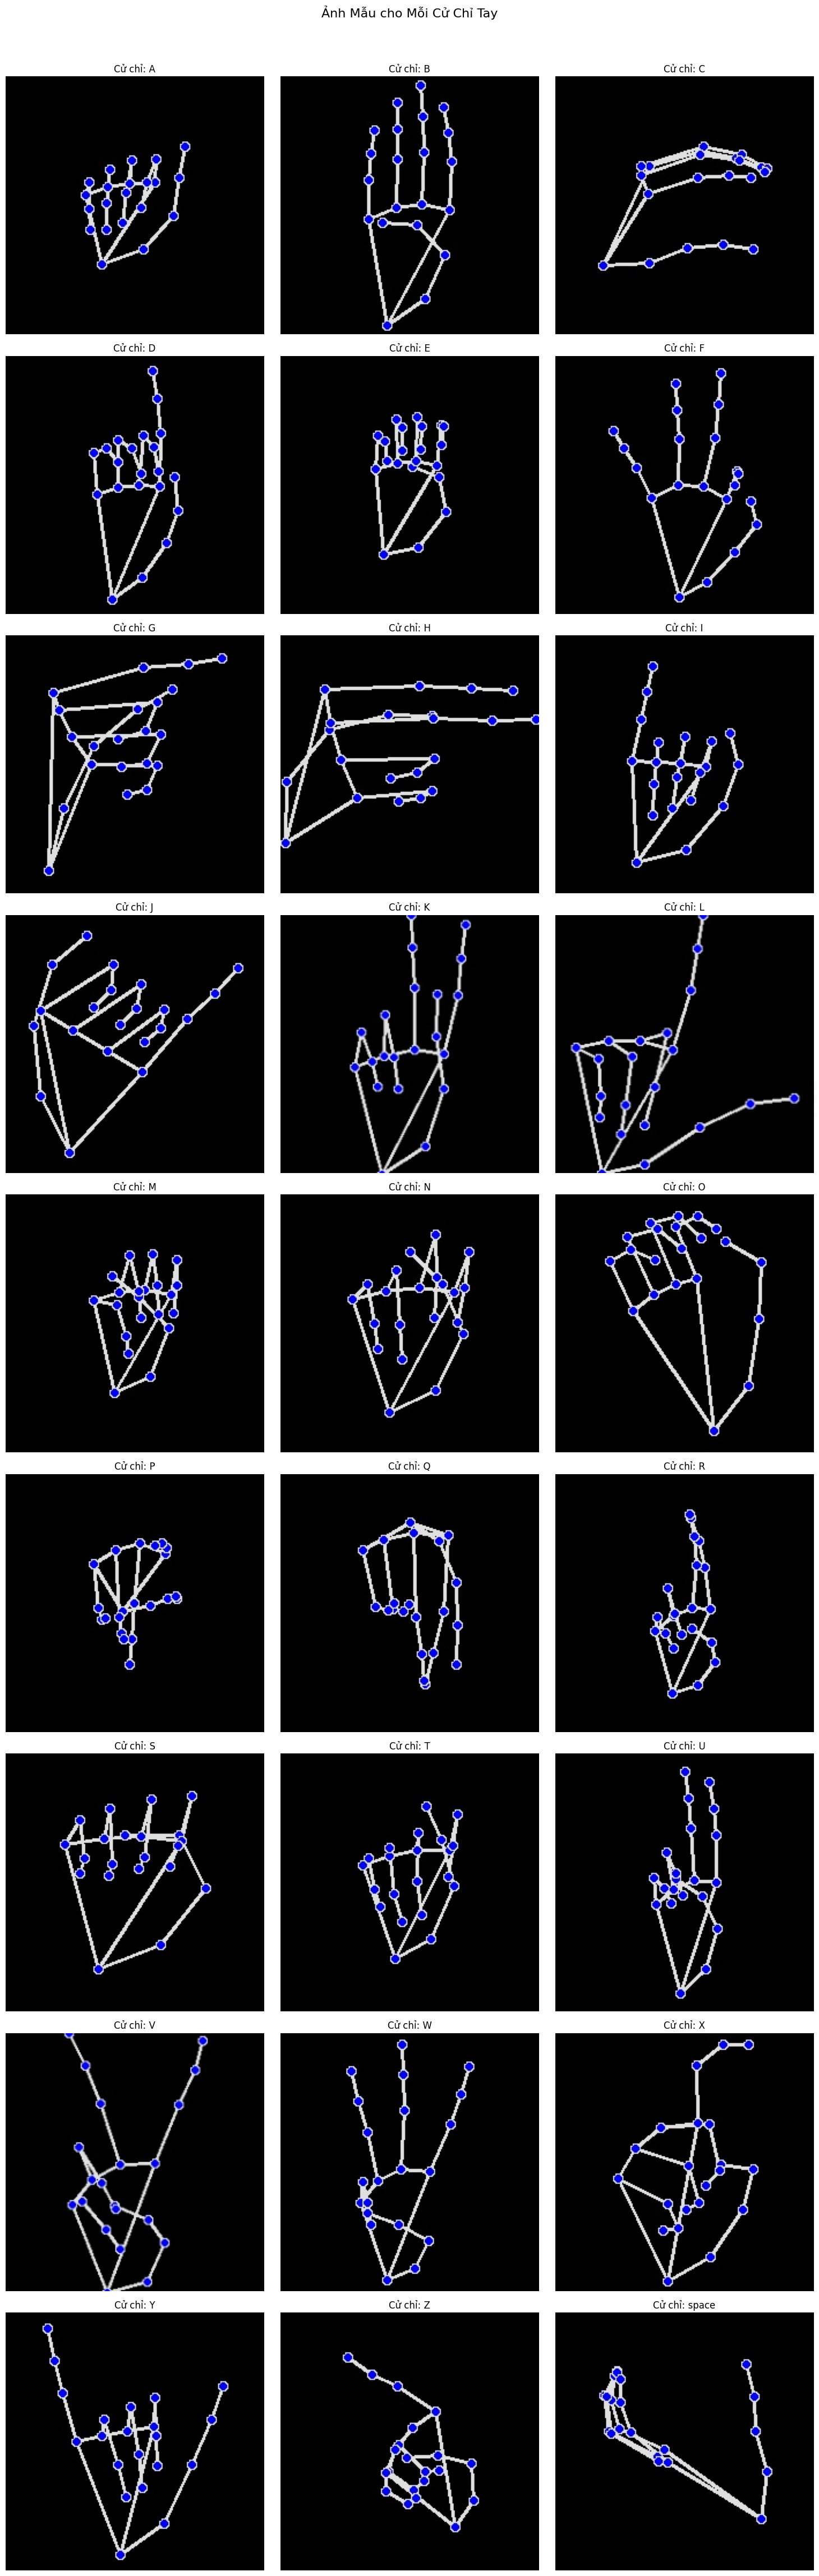

In [11]:
# Tạo subplot cho mỗi cử chỉ tay
unique_gestures = sorted(os.listdir(IMG_PATH))
n_gestures = len(unique_gestures)

# Tính số hàng và cột cho subplot
n_cols = 3
n_rows = (n_gestures + n_cols - 1) // n_cols

# Tạo figure với kích thước phù hợp
plt.figure(figsize=(15, 5*n_rows))

# Duyệt qua từng cử chỉ
for idx, gesture in enumerate(unique_gestures):
    # Lấy đường dẫn thư mục của cử chỉ
    gesture_path = os.path.join(IMG_PATH, gesture)
    
    # Lấy một ảnh mẫu từ thư mục
    sample_image_name = os.listdir(gesture_path)[0]
    sample_image_path = os.path.join(gesture_path, sample_image_name)
    
    # Đọc ảnh
    image = cv2.imread(sample_image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Tạo subplot
    plt.subplot(n_rows, n_cols, idx + 1)
    plt.imshow(image)
    plt.title(f'Cử chỉ: {gesture}')
    plt.axis('off')

plt.tight_layout()
plt.suptitle('Ảnh Mẫu cho Mỗi Cử Chỉ Tay', y=1.02, fontsize=16)
plt.show()


<Axes: xlabel='folder'>

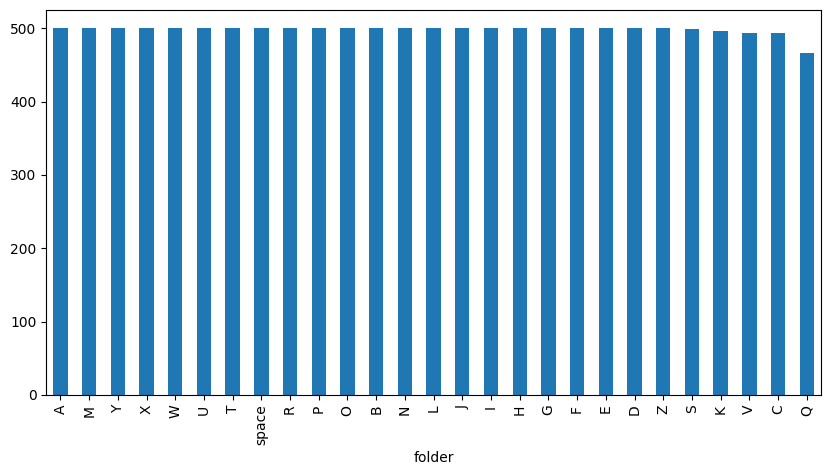

In [12]:
df["folder"].value_counts().plot(kind='bar', figsize=(10, 5))   

## Model

In [13]:
# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands

hands = mp_hands.Hands(
    static_image_mode=False, # Set to True for static images, False for video
    max_num_hands=2, # Maximum number of hands to detect
    min_detection_confidence=0.5, # Minimum detection confidence for hand detection
    min_tracking_confidence=0.5 # Minimum tracking confidence for hand landmarks
)

In [14]:
# Initialize MediaPipe Drawing
mp_drawing = mp.solutions.drawing_utils
drawing_spec = mp_drawing.DrawingSpec(thickness=1, # Thickness of the lines
                                     circle_radius=1, # Radius of the circles
                                     )

In [15]:
# Split data into features and labels
X = df.iloc[:, 2:]  # All columns except the folder and label columns   
y = df["folder"]   # Cột cuối cùng là nhãn

# Chia dữ liệu thành tập huấn luyện và tập kiểm thử
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
pipe = Pipeline([
    ('scaler', StandardScaler()),  # Chuẩn hóa dữ liệu
    ('svm', SVC())  # Sử dụng SVM với kernel RBF
])
param_grid = {
    'svm__C': [0.1, 1, 10], 
    'svm__gamma': [0.001, 0.01, 0.1, 1],
    'svm__kernel': ['rbf', 'linear']  # Sử dụng kernel RBF
}
grid_search = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, verbose=2)    

In [19]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svm', SVC())]),
             n_jobs=-1,
             param_grid={'svm__C': [0.1, 1, 10],
                         'svm__gamma': [0.001, 0.01, 0.1, 1],
                         'svm__kernel': ['rbf', 'linear']},
             verbose=2)

In [ ]:
# Đánh giá mô hình
y_pred = grid_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Độ chính xác của mô hình: {accuracy:.2f}")

# Lưu mô hình đã huấn luyện
with open("gesture_model.pkl", "wb") as f:
    pickle.dump(grid_search, f)
print("Mô hình đã được huấn luyện và lưu vào gesture_model.pkl")

Độ chính xác của mô hình: 1.00
Mô hình đã được huấn luyện và lưu vào gesture_model.pkl



Báo cáo phân loại chi tiết:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00       111
           B       1.00      1.00      1.00        99
           C       1.00      1.00      1.00        99
           D       1.00      1.00      1.00        93
           E       1.00      1.00      1.00       106
           F       1.00      1.00      1.00        91
           G       1.00      1.00      1.00       106
           H       1.00      1.00      1.00       105
           I       1.00      1.00      1.00       108
           J       1.00      1.00      1.00       102
           K       1.00      1.00      1.00        97
           L       1.00      1.00      1.00        90
           M       1.00      1.00      1.00        96
           N       1.00      1.00      1.00       103
           O       1.00      1.00      1.00        86
           P       1.00      1.00      1.00        85
           Q       1.00      1.00      1.00       10

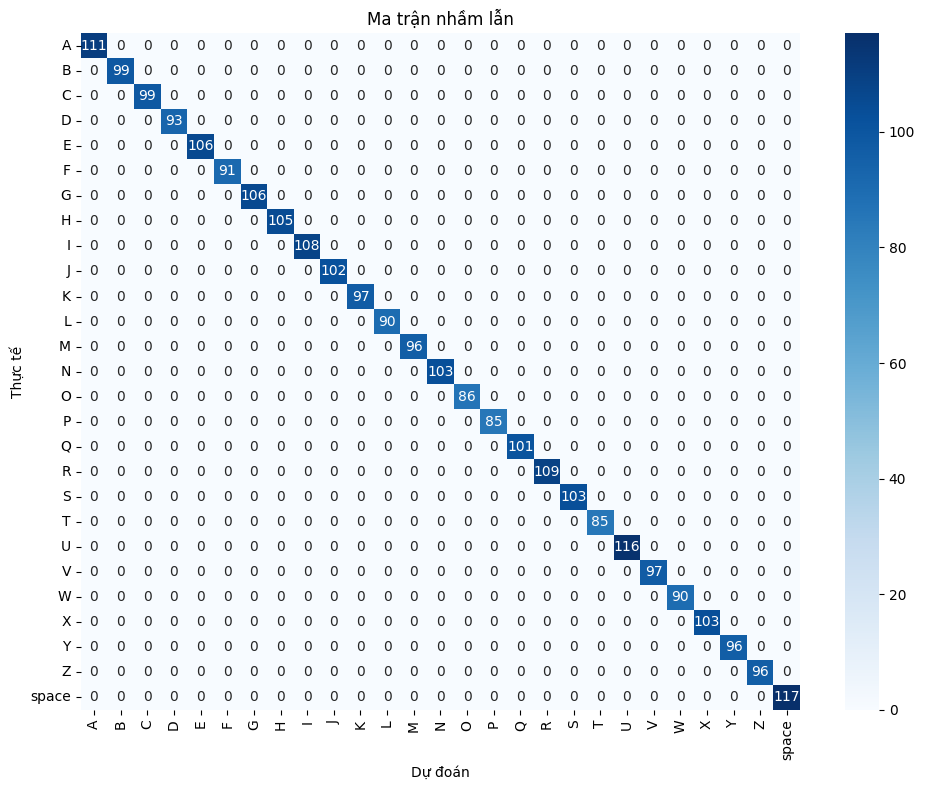

In [24]:
print("\nBáo cáo phân loại chi tiết:")
print(classification_report(y_test, y_pred))

# Tạo và hiển thị ma trận nhầm lẫn
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
classes = np.unique(y_test)

# Vẽ ma trận nhầm lẫn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes,
            yticklabels=classes)
plt.title('Ma trận nhầm lẫn')
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.tight_layout()
plt.show()

In [ ]:
# Load trained gesture model
with open("gesture_model.pkl", "rb") as f:
    model = pickle.load(f)

# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.5)

# Initialize MediaPipe Drawing
mp_drawing = mp.solutions.drawing_utils
drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)

# Initialize webcam
cap = cv2.VideoCapture(0)

print("Bắt đầu phân loại cử chỉ tay trong thời gian thực...")

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = hands.process(frame_rgb)

    gesture_text = "None"

    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            # Get and normalize hand landmark coordinates
            landmarks = np.array([[lm.x, lm.y] for lm in hand_landmarks.landmark]).flatten().reshape(1, -1)

            # Predict gesture
            prediction = model.predict(landmarks)
            gesture_text = prediction[0]

            # Draw hand landmarks on frame
            mp_drawing.draw_landmarks(
                image=frame,
                landmark_list=hand_landmarks,
                connections=mp_hands.HAND_CONNECTIONS,
                landmark_drawing_spec=drawing_spec,
                connection_drawing_spec=drawing_spec
            )

    cv2.putText(frame, f"Gesture: {gesture_text}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.imshow("Real-time Gesture Classification", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


Bắt đầu phân loại cử chỉ tay trong thời gian thực...


c:\Users\PC\Deskop\Hand_Landmark_by_Mediapipe\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\PC\Deskop\Hand_Landmark_by_Mediapipe\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\PC\Deskop\Hand_Landmark_by_Mediapipe\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\PC\Deskop\Hand_Landmark_by_Mediapipe\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\PC\Deskop\Hand_Landmark_by_Mediapipe\myenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X d

: 

In [ ]:
# Khởi tạo MediaPipe và PyAutoGUI
mp_hands = mp.solutions.hands
hands = mp_hands.Hands()
pyautogui.FAILSAFE = False # Tắt tính năng an toàn để tránh bị ngắt kết nối

# Bắt đầu webcam
cap = cv2.VideoCapture(0)

while cap.isOpened():
    success, image = cap.read()
    if not success:
        continue

    # Xử lý hình ảnh với MediaPipe
    image.flags.writeable = False
    results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            # Lấy tọa độ các điểm mốc
            # Ví dụ: lấy tọa độ ngón cái
            thumb_tip_y = hand_landmarks.landmark[mp_hands.HandLandmark.THUMB_TIP].y

            # Định nghĩa cử chỉ cuộn
            if thumb_tip_y < 100:  # Ngón cái giơ lên (có thể điều chỉnh ngưỡng này)
                # Nếu ngón cái giơ lên, cuộn chuột lên
                pyautogui.scroll(100)

            # Thêm các logic khác cho các cử chỉ khác...

    cv2.imshow("Hand Gesture Control", cv2.flip(image, 1))
    if cv2.waitKey(5) & 0xFF == 27: # Nhấn Esc để thoát
        break

cap.release()

Cuộn lên!
Cuộn lên!
Cuộn lên!
Cuộn lên!
Cuộn lên!
Cuộn lên!
Cuộn lên!
Cuộn lên!
Cuộn lên!
Cuộn lên!
Cuộn lên!
Cuộn lên!
Cuộn lên!
Cuộn lên!
Cuộn lên!
Cuộn lên!
Cuộn lên!
Cuộn lên!
Cuộn lên!
Cuộn lên!
Cuộn lên!
Cuộn lên!
Cuộn lên!
Cuộn lên!
Cuộn lên!
Cuộn lên!
Cuộn lên!
Cuộn lên!
Cuộn lên!
Cuộn lên!
Cuộn lên!
Cuộn lên!
Cuộn lên!
Cuộn lên!
Cuộn lên!
Cuộn lên!
Cuộn lên!
Cuộn lên!
Cuộn lên!
Cuộn lên!
Cuộn lên!
Cuộn lên!
Cuộn lên!
Cuộn lên!
Cuộn lên!
Cuộn lên!
Cuộn lên!
Cuộn lên!
Cuộn lên!
Cuộn lên!
Cuộn lên!
Cuộn lên!
Cuộn lên!
Cuộn lên!
Cuộn lên!
Cuộn lên!
Cuộn lên!
Cuộn lên!
Cuộn lên!
Cuộn lên!
Cuộn lên!
Cuộn lên!
Cuộn lên!
Cuộn lên!
Cuộn lên!
Cuộn lên!
Cuộn lên!
Cuộn lên!
Cuộn lên!
Cuộn lên!
Cuộn lên!
Cuộn lên!
Cuộn lên!
Cuộn lên!
Cuộn lên!
Cuộn lên!
Cuộn lên!
Cuộn lên!
Cuộn lên!
Cuộn lên!


KeyboardInterrupt: 

: 